<a href="https://colab.research.google.com/github/Megdadi/Cleaning_data/blob/main/author_data_RandomForest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Load libraries
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
from gensim.utils import simple_preprocess
from sklearn.feature_extraction.text import CountVectorizer
from scipy.spatial import transform
from sklearn.feature_extraction.text import TfidfTransformer

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, SimpleRNN,BatchNormalization
from keras.datasets import imdb
from keras.callbacks import TensorBoard




# **Preprocessing**

# **first read the files into a python dataframe for further processing and visualization.**

In [325]:
data=pd.read_csv('/content/drive/MyDrive/RNN/author_data/ML-Test/author_data.csv')
print(data.shape,'\n')
####
print(data.head(),'\n')
####
print(data['author'].value_counts())

(19579, 3) 

        id                                               text author
0  id26305  This process, however, afforded me no means of...    EAP
1  id17569  It never once occurred to me that the fumbling...    HPL
2  id11008  In his left hand was a gold snuff box, from wh...    EAP
3  id27763  How lovely is spring As we looked from Windsor...    MWS
4  id12958  Finding nothing else, not even gold, the Super...    HPL 

EAP    7900
MWS    6044
HPL    5635
Name: author, dtype: int64


In [326]:
#check missing values
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19579 entries, 0 to 19578
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      19579 non-null  object
 1   text    19579 non-null  object
 2   author  19579 non-null  object
dtypes: object(3)
memory usage: 459.0+ KB


In [327]:
 # Find NAN
missing= data.isnull().sum().sort_values(ascending= False)
print(missing)

nan_df = data[data.isnull().any(axis=1)]
len(nan_df)

id        0
text      0
author    0
dtype: int64


0

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


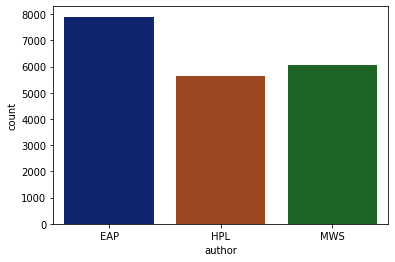

In [328]:
sns.countplot('author', data = data, palette='dark')

In [329]:
#labels = {'EAP': 0, 'MWS': 1, 'HPL': 2}


# **Splitting data to train-test ( 25% for testing)**

In [330]:
data['word_count'] = data['text'].str.count(' ')
data.head()

,id,text,author,word_count
0,id26305,"This process, however, afforded me no means of...",EAP,40
1,id17569,It never once occurred to me that the fumbling...,HPL,13
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP,35
3,id27763,How lovely is spring As we looked from Windsor...,MWS,33
4,id12958,"Finding nothing else, not even gold, the Super...",HPL,26


In [331]:
data[data["author"] == "EAP"]["word_count"].describe()


count    7900.000000
mean       24.442405
std        18.567706
min         1.000000
25%        11.000000
50%        20.000000
75%        32.000000
max       266.000000
Name: word_count, dtype: float64

In [332]:
data[data["author"] == "MWS"]["word_count"].describe()


count    6044.000000
mean       26.417273
std        23.134440
min         1.000000
25%        14.000000
50%        22.000000
75%        33.000000
max       860.000000
Name: word_count, dtype: float64

In [333]:
data[data["author"] == "HPL"]["word_count"].describe()


count    5635.000000
mean       26.799645
std        14.123252
min         3.000000
25%        17.000000
50%        25.000000
75%        34.000000
max       146.000000
Name: word_count, dtype: float64

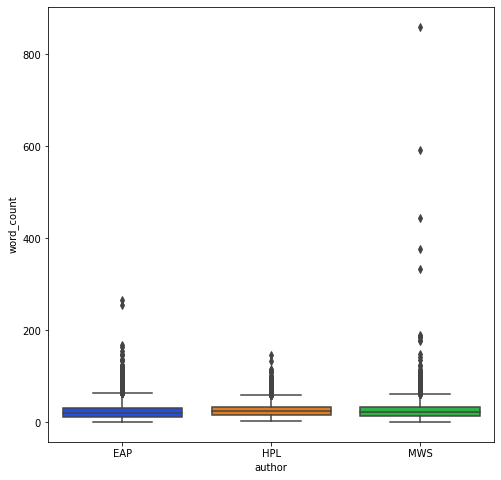

In [334]:
plt.figure(figsize=(8,8))
sns.boxplot(x="author", y="word_count", data=data, palette='bright');

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

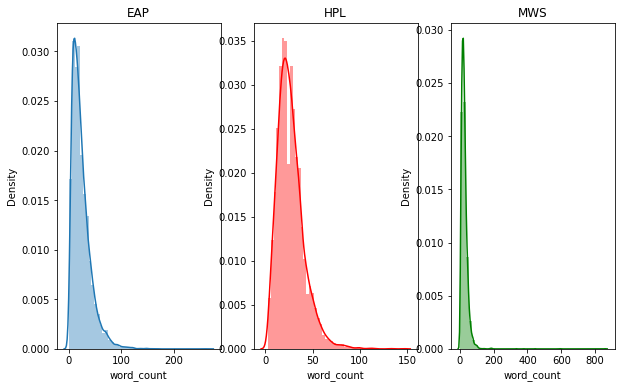

In [335]:
f,ax=plt.subplots(1,3,figsize=(10,6));
sns.distplot(data[data['author']=='EAP'].word_count,ax=ax[0]);
ax[0].set_title('EAP');
sns.distplot(data[data['author']=='HPL'].word_count,ax=ax[1], color='r')
ax[1].set_title('HPL');
sns.distplot(data[data['author']=='MWS'].word_count,ax=ax[2], color='g')
ax[2].set_title('MWS');
plt.show();

# **Preprocessing and feature extraction**

In [336]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word.lower() for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
data_train = remove_stopwords(data['text'])


In [337]:
data['text'].iloc[0]

'This process, however, afforded me no means of ascertaining the dimensions of my dungeon; as I might make its circuit, and return to the point whence I set out, without being aware of the fact; so perfectly uniform seemed the wall.'

In [338]:
data_train[0]

['process',
 'however',
 'afforded',
 'means',
 'ascertaining',
 'dimensions',
 'dungeon',
 'might',
 'make',
 'circuit',
 'return',
 'point',
 'whence',
 'set',
 'without',
 'aware',
 'fact',
 'perfectly',
 'uniform',
 'seemed',
 'wall']

# **We use TfidTransformer to covert the text into the feature vectors, we restrict the maximum features to 10000**

In [339]:
train_text = [' '.join(sent) for sent in data_train]


In [340]:
train_text[0]

'process however afforded means ascertaining dimensions dungeon might make circuit return point whence set without aware fact perfectly uniform seemed wall'

In [341]:
# Initialize the "CountVectorizer" object, which is scikit-learn's
# bag of words tool.  
vectorizer = CountVectorizer(analyzer = "word",                             
                             max_features = 10000)

feature_vec = vectorizer.fit_transform(train_text)

In [342]:
trans = TfidfTransformer(use_idf=True).fit(feature_vec)
X_train = trans.transform(feature_vec)
X_train.shape

(19579, 10000)

In [344]:
# create train/test set
train_data = X_train
train_labels = data["author"]
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(train_data,train_labels,test_size=0.25,random_state=0)

In [366]:
from sklearn.ensemble import RandomForestClassifier
clf1 = RandomForestClassifier().fit(X_train, y_train)
predicted = clf1.predict(X_test)
predicted_propa = clf1.predict_proba(X_test)

print(accuracy_score(y_test,predicted))
print(log_loss(y_test, predicted_propa))

0.6976506639427987
0.7210263962248483


# **We can use athor models which is better**

In [367]:
from sklearn.linear_model import SGDClassifier
clf2 = SGDClassifier().fit(X_train, y_train)

predicted = clf2.predict(X_test)

print(accuracy_score(y_test,predicted))


0.8096016343207354


In [368]:
from sklearn.ensemble import GradientBoostingClassifier
clf3 = GradientBoostingClassifier(n_estimators=150, learning_rate=0.6,max_depth=3, random_state=0).fit(X_train, y_train)
predicted = clf3.predict(X_test)
predicted_propa = clf3.predict_proba(X_test)

print(accuracy_score(y_test,predicted))
print(log_loss(y_test, predicted_propa))

0.7139938712972421
0.6902748602347587


In [369]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, log_loss
clf4 = MultinomialNB().fit(X_train, y_train)

predicted = clf4.predict(X_test)
predicted_propa = clf4.predict_proba(X_test)

print(accuracy_score(y_test,predicted))
print(log_loss(y_test, predicted_propa))


0.819611848825332
0.5919632430680485


In [347]:
### Function to create confusion matrix ###
import itertools
from sklearn.metrics import confusion_matrix

### From http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py #
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    #else:
    #    print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

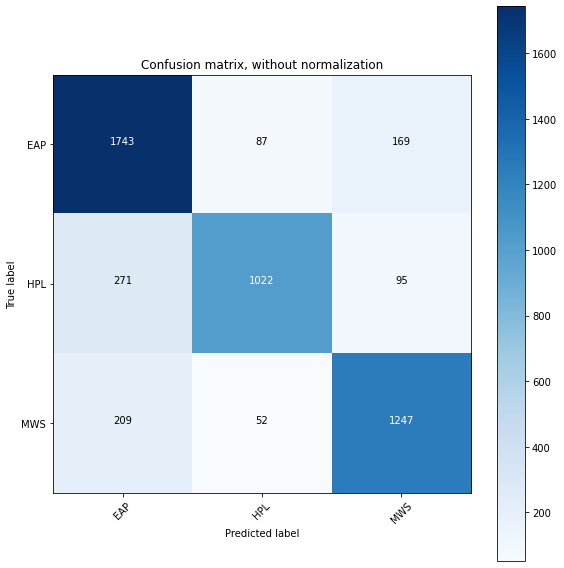

In [372]:
cnf_matrix = confusion_matrix(y_test,predicted)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf_matrix, classes=['EAP', 'HPL', 'MWS'],
                      title='Confusion matrix, without normalization')
plt.show()

# **Ensemble**

In [370]:
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import cross_val_score
eclf = VotingClassifier(
    estimators=[('lr', clf1), ('rf', clf2), ('gnb', clf4)],
    voting='hard')

for clf, label in zip([clf1, clf2, clf4, eclf], ['RandomForest', 'SGDClassifier', 'naive Bayes', 'Ensemble']):
  scores = cross_val_score(clf, X_train, y_train, scoring='accuracy', cv=5)
  print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

Accuracy: 0.70 (+/- 0.01) [RandomForest]
Accuracy: 0.80 (+/- 0.00) [SGDClassifier]
Accuracy: 0.81 (+/- 0.01) [naive Bayes]
Accuracy: 0.81 (+/- 0.01) [Ensemble]


# **RNN**

In [15]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, SimpleRNN
from keras.callbacks import TensorBoard
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
import re
from keras.layers import LSTM, GRU


In [6]:
data = pd.read_csv('/content/drive/MyDrive/RNN/author_data/ML-Test/author_data.csv')
# Keeping only the neccessary columns

data = data[['text','author']]
data.head()

,text,author
0,"This process, however, afforded me no means of...",EAP
1,It never once occurred to me that the fumbling...,HPL
2,"In his left hand was a gold snuff box, from wh...",EAP
3,How lovely is spring As we looked from Windsor...,MWS
4,"Finding nothing else, not even gold, the Super...",HPL


# **[Cleaning the Dataset]**

In [7]:
data['text'] = data['text'].apply(lambda x: x.lower())
data['text'] = data['text'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))
data['text'] = data['text'].apply((lambda x: re.sub(r"https?:\/\/t.co\/[A-Za-z0-9]+",'',x)))
data['text'] = data['text'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))
data['text'] = data['text'].apply((lambda x: re.sub('[<.*?>+]','', x)))


In [26]:
data.head()

,text,author
0,this process however afforded me no means of a...,EAP
1,it never once occurred to me that the fumbling...,HPL
2,in his left hand was a gold snuff box from whi...,EAP
3,how lovely is spring as we looked from windsor...,MWS
4,finding nothing else not even gold the superin...,HPL


In [27]:
# I define the number of max features as 2000 and use Tokenizer to vectorize 
# and convert text into Sequences so the Network can deal with it as input.
max_fatures = 10000
tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(data['text'].values)
X = tokenizer.texts_to_sequences(data['text'].values)
X = pad_sequences(X)
Y = pd.get_dummies(data['author']).values

In [28]:
no_classes=3
batch_size = 128
dropout_rate = 0.4
embedding_size=32
hidden_layer_size = 256
no_epochs = 15
RNN_model = Sequential()
# Add Embedding layer
RNN_model.add(Embedding(max_fatures, embedding_size, input_length=X.shape[1]))
RNN_model.add(Dropout(dropout_rate))
# Add Simple RNN layer
RNN_model.add(SimpleRNN(64, activation='relu', batch_input_shape=(batch_size, X.shape[1], 1)))

# Add Dense Hidden Layer
RNN_model.add(Dense(hidden_layer_size, activation='relu'))
RNN_model.add(Dropout(dropout_rate))
RNN_model.add(BatchNormalization())


# Output Layer
RNN_model.add(Dense(no_classes, activation='softmax'))
RNN_model.compile(loss = 'categorical_crossentropy', optimizer='Adam', metrics = ['accuracy'])
print(RNN_model.summary())

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 846, 32)           320000    
                                                                 
 dropout_9 (Dropout)         (None, 846, 32)           0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 64)                6208      
                                                                 
 dense_13 (Dense)            (None, 256)               16640     
                                                                 
 dropout_10 (Dropout)        (None, 256)               0         
                                                                 
 batch_normalization_5 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                      

In [29]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.02, random_state = 42)
X_train, X_val, Y_train, Y_val = train_test_split(X_train,Y_train, test_size = 0.25, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_val.shape,Y_val.shape)
print(X_test.shape,Y_test.shape)


(14390, 846) (14390, 3)
(4797, 846) (4797, 3)
(392, 846) (392, 3)


In [30]:
import tensorflow as tf

In [31]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2)


In [103]:
history = RNN_model.fit(X_train, Y_train, batch_size=batch_size, epochs=no_epochs, validation_data=(X_val, Y_val),callbacks=[callback])

   

Epoch 1/15
57/57 [==============================] - 44s 754ms/step - loss: 1.3577 - accuracy: 0.3493 - val_loss: 1.0886 - val_accuracy: 0.4030
Epoch 2/15
57/57 [==============================] - 43s 750ms/step - loss: 1.2047 - accuracy: 0.3777 - val_loss: 1.0874 - val_accuracy: 0.4184
Epoch 3/15
57/57 [==============================] - 43s 761ms/step - loss: 1.1110 - accuracy: 0.4197 - val_loss: 1.0907 - val_accuracy: 0.3677
Epoch 4/15
57/57 [==============================] - 42s 745ms/step - loss: 0.9771 - accuracy: 0.5273 - val_loss: 0.9851 - val_accuracy: 0.5689
Epoch 5/15
57/57 [==============================] - 48s 848ms/step - loss: 0.7288 - accuracy: 0.6858 - val_loss: 0.8734 - val_accuracy: 0.6581
Epoch 6/15
57/57 [==============================] - 42s 739ms/step - loss: 0.4896 - accuracy: 0.8130 - val_loss: 0.6782 - val_accuracy: 0.7536
Epoch 7/15
57/57 [==============================] - 43s 747ms/step - loss: 0.3606 - accuracy: 0.8646 - val_loss: 0.5510 - val_accuracy: 0.7753

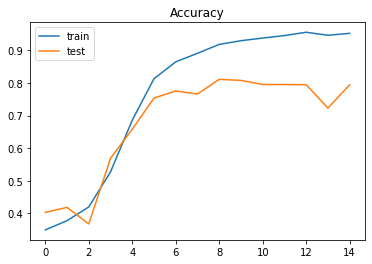

In [104]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

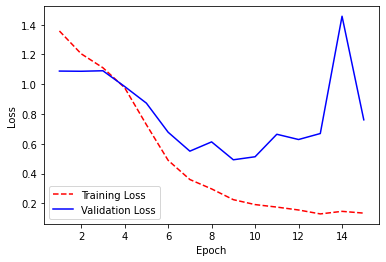

In [106]:
epoch_count = range(1, len(history.history['loss']) + 1)
plt.plot(epoch_count, history.history['loss'], 'r--')
plt.plot(epoch_count, history.history['val_loss'], 'b-')
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# **LSTM**

In [32]:
no_classes=3
batch_size = 128
dropout_rate = 0.4
embedding_size=32
hidden_layer_size = 256
no_epochs = 15

In [ ]:
embed_dim = 128
lstm_out = 196

model = Sequential()
model.add(Embedding(300, embed_dim,input_length = X.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))

# Add Dense Hidden Layer
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.4))
model.add(BatchNormalization())

model.add(Dense(3,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())
history = model.fit(X_train, Y_train, batch_size=128, epochs=16, validation_data=(X_val, Y_val),callbacks=[callback])


# **GRU**

In [21]:
embed_dim = 128

model_GRU = Sequential()
model_GRU.add(Embedding(300, embed_dim,input_length = X.shape[1]))
model_GRU.add(SpatialDropout1D(0.3))
model_GRU.add(GRU(300, dropout=0.3, recurrent_dropout=0.3, return_sequences=True))
model_GRU.add(GRU(300, dropout=0.3, recurrent_dropout=0.3))

model_GRU.add(Dense(256, activation='relu'))
model_GRU.add(Dropout(0.4))

model_GRU.add(Dense(128, activation='relu'))
model_GRU.add(Dropout(0.4))
model_GRU.add(BatchNormalization())


model_GRU.add(Dense(3,activation='softmax'))
model_GRU.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model_GRU.summary())
history = model_GRU.fit(X_train, Y_train, batch_size=128, epochs=16, validation_data=(X_val, Y_val),callbacks=[callback])


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 846, 128)          38400     
                                                                 
 spatial_dropout1d_4 (Spatia  (None, 846, 128)         0         
 lDropout1D)                                                     
                                                                 
 gru_6 (GRU)                 (None, 846, 300)          387000    
                                                                 
 gru_7 (GRU)                 (None, 300)               541800    
                                                                 
 dense_6 (Dense)             (None, 256)               77056     
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                      